# Setting up kaggle to download dataset

We're gonna be using the anime face dataset from Kaggle. https://www.kaggle.com/datasets/splcher/animefacedataset

This contains 63000 images of anime characters. Visit the website for more information.

In [7]:
!pip install -q kaggle

In [8]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download splcher/animefacedataset

 98% 388M/395M [00:03<00:00, 223MB/s]
100% 395M/395M [00:03<00:00, 133MB/s]


In [11]:
!mkdir ./animefacedataset

mkdir: cannot create directory ‘./animefacedataset’: File exists


In [12]:
!unzip -q animefacedataset.zip -d ./animefacedataset

# Checking out if our dataset is correctly downloaded

In [9]:
project_name = '06b-anime-dcgan'

import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [10]:
print(os.listdir(DATA_DIR+'/images')[:10])

['13988_2006.jpg', '47837_2014.jpg', '5860_2003.jpg', '14126_2006.jpg', '59706_2018.jpg', '58084_2017.jpg', '279_2000.jpg', '16817_2007.jpg', '8841_2004.jpg', '18323_2007.jpg']


# Creating a PyTorch Dataset and DataLoader

In [11]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [12]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as transforms

In [13]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [14]:
# Creating a transform for our images
img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*stats)  # Normalize with mean and std 0.5 for each channel
])

In [15]:
train_dataset = ImageFolder(root=DATA_DIR,
                            transform=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

In [16]:
images, _ = next(iter(train_dataloader))
images.shape, _.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [21]:
_.unique(), _[:10]

(tensor([0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# Creating helper functions to denormalize images and visualize images from a training batch.

In [21]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def denorm(img_tensors):
  return img_tensors * stats[0][1] + stats[0][0]

In [39]:
def show_images(dataloader, nmax=64):
  images, _ = next(iter(dataloader))
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

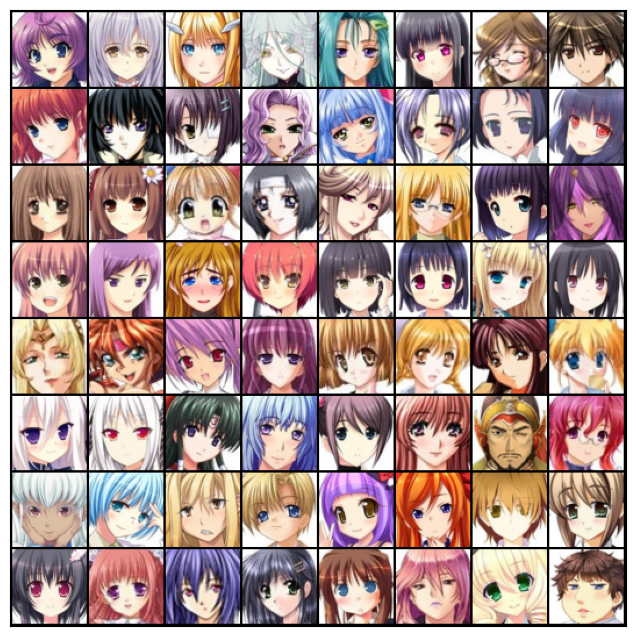

In [42]:
show_images(train_dataloader)

# Creating the discriminator

In [43]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    )

In [46]:
# Move model to target device
discriminator = discriminator.to(device)

In [47]:
# Check which device our model is on.
next(discriminator.parameters()).device

device(type='cuda', index=0)

# Creating the Generator

In [48]:
latent_size = 128

In [49]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [50]:
generator = generator.to(device)